In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import utils

In [2]:
video_name = "JustSomeMotion_CaravanPalace_Brotherswing"
path = "./data/video/{0}.mp4".format(video_name)
pose_dir = './data/poses/{0}'.format(video_name)
print(path)

step_size = 10

./data/video/JustSomeMotion_CaravanPalace_Brotherswing.mp4


In [3]:
utils.convert_video_to_frames(path, pose_dir, step_size)

Read a new frame: 0 True
Read a new frame: 10 True
Read a new frame: 20 True
Read a new frame: 30 True
Read a new frame: 40 True
Read a new frame: 50 True
Read a new frame: 60 True
Read a new frame: 70 True
Read a new frame: 80 True
Read a new frame: 90 True
Read a new frame: 100 True
Read a new frame: 110 True
Read a new frame: 120 True
Read a new frame: 130 True
Read a new frame: 140 True
Read a new frame: 150 True
Read a new frame: 160 True
Read a new frame: 170 True
Read a new frame: 180 True
Read a new frame: 190 True
Read a new frame: 200 True
Read a new frame: 210 True
Read a new frame: 220 True
Read a new frame: 230 True
Read a new frame: 240 True
Read a new frame: 250 True
Read a new frame: 260 True
Read a new frame: 270 True
Read a new frame: 280 True
Read a new frame: 290 True
Read a new frame: 300 True
Read a new frame: 310 True
Read a new frame: 320 True
Read a new frame: 330 True
Read a new frame: 340 True
Read a new frame: 350 True
Read a new frame: 360 True
Read a new f

Read a new frame: 2970 True
Read a new frame: 2980 True
Read a new frame: 2990 True
Read a new frame: 3000 True
Read a new frame: 3010 True
Read a new frame: 3020 True
Read a new frame: 3030 True
Read a new frame: 3040 True
Read a new frame: 3050 True
Read a new frame: 3060 True
Read a new frame: 3070 True
Read a new frame: 3080 True
Read a new frame: 3090 True
Read a new frame: 3100 True
Read a new frame: 3110 True
Read a new frame: 3120 True
Read a new frame: 3130 True
Read a new frame: 3140 True
Read a new frame: 3150 True
Read a new frame: 3160 True
Read a new frame: 3170 True
Read a new frame: 3180 True
Read a new frame: 3190 True
Read a new frame: 3200 True
Read a new frame: 3210 True
Read a new frame: 3220 True
Read a new frame: 3230 True
Read a new frame: 3240 True
Read a new frame: 3250 True
Read a new frame: 3260 True
Read a new frame: 3270 True
Read a new frame: 3280 True
Read a new frame: 3290 True
Read a new frame: 3300 True
Read a new frame: 3310 True
Read a new frame: 33

Read a new frame: 5940 True
Read a new frame: 5950 True
Read a new frame: 5960 True
Read a new frame: 5970 True
Read a new frame: 5980 True
Read a new frame: 5990 True
Read a new frame: 6000 True
Read a new frame: 6010 True
Read a new frame: 6020 True
Read a new frame: 6030 True
Read a new frame: 6040 True
Read a new frame: 6050 True
Read a new frame: 6060 True
Read a new frame: 6070 True
Read a new frame: 6080 True
Read a new frame: 6090 True
Read a new frame: 6100 True
Read a new frame: 6110 True
Read a new frame: 6120 True
Read a new frame: 6130 True
Read a new frame: 6140 True
Read a new frame: 6150 True
Read a new frame: 6160 True
Read a new frame: 6170 True
Read a new frame: 6180 True
Read a new frame: 6190 True
Read a new frame: 6200 True
Read a new frame: 6210 True
Read a new frame: 6220 True
Read a new frame: 6230 True
Read a new frame: 6240 True
Read a new frame: 6250 True
Read a new frame: 6260 True
Read a new frame: 6270 True
Read a new frame: 6280 True
Read a new frame: 62

Read a new frame: 8900 True
Read a new frame: 8910 True
Read a new frame: 8920 True
Read a new frame: 8930 True
Read a new frame: 8940 True
Read a new frame: 8950 True
Read a new frame: 8960 True
Read a new frame: 8970 True
Read a new frame: 8980 True
Read a new frame: 8990 True
Read a new frame: 9000 True
Read a new frame: 9010 True
Read a new frame: 9020 True
Read a new frame: 9030 True
Read a new frame: 9040 True
Read a new frame: 9050 True
Read a new frame: 9060 True
Read a new frame: 9070 True
Read a new frame: 9080 True
Read a new frame: 9090 True
Read a new frame: 9100 True
Read a new frame: 9110 True
Read a new frame: 9120 True
Read a new frame: 9130 True
Read a new frame: 9140 True
Read a new frame: 9150 True
Read a new frame: 9160 True
Read a new frame: 9170 True
Read a new frame: 9180 True
Read a new frame: 9190 True
Read a new frame: 9200 True
Read a new frame: 9210 True
Read a new frame: 9220 True
Read a new frame: 9230 True
Read a new frame: 9240 True
Read a new frame: 92

Read a new frame: 11800 True
Read a new frame: 11810 True
Read a new frame: 11820 True
Read a new frame: 11830 True
Read a new frame: 11840 True
Read a new frame: 11850 True
Read a new frame: 11860 True
Read a new frame: 11870 True
Read a new frame: 11880 True
Read a new frame: 11890 True
Read a new frame: 11900 True
Read a new frame: 11910 True
Read a new frame: 11920 True
Read a new frame: 11930 True
Read a new frame: 11940 True
Read a new frame: 11950 True
Read a new frame: 11960 True
Read a new frame: 11970 True
Read a new frame: 11980 True
Read a new frame: 11990 True
Read a new frame: 12000 True
Read a new frame: 12010 True
Read a new frame: 12020 True
Read a new frame: 12030 True
Read a new frame: 12040 True
Read a new frame: 12050 True
Read a new frame: 12060 True
Read a new frame: 12070 True
Read a new frame: 12080 True
Read a new frame: 12090 True
Read a new frame: 12100 True
Read a new frame: 12110 True
Read a new frame: 12120 True
Read a new frame: 12130 True
Read a new fra

Read a new frame: 14650 True
Read a new frame: 14660 True
Read a new frame: 14670 True
Read a new frame: 14680 True
Read a new frame: 14690 True
Read a new frame: 14700 True
Read a new frame: 14710 True
Read a new frame: 14720 True
Read a new frame: 14730 True
Read a new frame: 14740 True
Read a new frame: 14750 True
Read a new frame: 14760 True
Read a new frame: 14770 True
Read a new frame: 14780 True
Read a new frame: 14790 True
Read a new frame: 14800 True
Read a new frame: 14810 True
Read a new frame: 14820 True
Read a new frame: 14830 True
Read a new frame: 14840 True
Read a new frame: 14850 True
Read a new frame: 14860 True
Read a new frame: 14870 True
Read a new frame: 14880 True
Read a new frame: 14890 True
Read a new frame: 14900 True
Read a new frame: 14910 True
Read a new frame: 14920 True
Read a new frame: 14930 True
Read a new frame: 14940 True
Read a new frame: 14950 True
Read a new frame: 14960 True
Read a new frame: 14970 True
Read a new frame: 14980 True
Read a new fra

Read a new frame: 17550 True
Read a new frame: 17560 True
Read a new frame: 17570 True
Read a new frame: 17580 True
Read a new frame: 17590 True
Read a new frame: 17600 True
Read a new frame: 17610 True
Read a new frame: 17620 True
Read a new frame: 17630 True
Read a new frame: 17640 True
Read a new frame: 17650 True
Read a new frame: 17660 True
Read a new frame: 17670 True
Read a new frame: 17680 True
Read a new frame: 17690 True
Read a new frame: 17700 True
Read a new frame: 17710 True
Read a new frame: 17720 True
Read a new frame: 17730 True
Read a new frame: 17740 True
Read a new frame: 17750 True
Read a new frame: 17760 True
Read a new frame: 17770 True
Read a new frame: 17780 True
Read a new frame: 17790 True
Read a new frame: 17800 True
Read a new frame: 17810 True
Read a new frame: 17820 True
Read a new frame: 17830 True
Read a new frame: 17840 True
Read a new frame: 17850 True
Read a new frame: 17860 True
Read a new frame: 17870 True
Read a new frame: 17880 True
Read a new fra

Read a new frame: 20440 True
Read a new frame: 20450 True
Read a new frame: 20460 True
Read a new frame: 20470 True
Read a new frame: 20480 True
Read a new frame: 20490 True
Read a new frame: 20500 True
Read a new frame: 20510 True
Read a new frame: 20520 True
Read a new frame: 20530 True
Read a new frame: 20540 True
Read a new frame: 20550 True
Read a new frame: 20560 True
Read a new frame: 20570 True
Read a new frame: 20580 True
Read a new frame: 20590 True
Read a new frame: 20600 True
Read a new frame: 20610 True
Read a new frame: 20620 True
Read a new frame: 20630 True
Read a new frame: 20640 True
Read a new frame: 20650 True
Read a new frame: 20660 True
Read a new frame: 20670 True
Read a new frame: 20680 True
Read a new frame: 20690 True
Read a new frame: 20700 True
Read a new frame: 20710 True
Read a new frame: 20720 True
Read a new frame: 20730 True
Read a new frame: 20740 True
Read a new frame: 20750 True
Read a new frame: 20760 True
Read a new frame: 20770 True
Read a new fra

Read a new frame: 23330 True
Read a new frame: 23340 True
Read a new frame: 23350 True
Read a new frame: 23360 True
Read a new frame: 23370 True
Read a new frame: 23380 True
Read a new frame: 23390 True
Read a new frame: 23400 True
Read a new frame: 23410 True
Read a new frame: 23420 True
Read a new frame: 23430 True
Read a new frame: 23440 True
Read a new frame: 23450 True
Read a new frame: 23460 True
Read a new frame: 23470 True
Read a new frame: 23480 True
Read a new frame: 23490 True
Read a new frame: 23500 True
Read a new frame: 23510 True
Read a new frame: 23520 True
Read a new frame: 23530 True
Read a new frame: 23540 True
Read a new frame: 23550 True
Read a new frame: 23560 True
Read a new frame: 23570 True
Read a new frame: 23580 True
Read a new frame: 23590 True
Read a new frame: 23600 True
Read a new frame: 23610 True
Read a new frame: 23620 True
Read a new frame: 23630 True
Read a new frame: 23640 True
Read a new frame: 23650 True
Read a new frame: 23660 True
Read a new fra

Read a new frame: 26210 True
Read a new frame: 26220 True
Read a new frame: 26230 True
Read a new frame: 26240 True
Read a new frame: 26250 True
Read a new frame: 26260 True
Read a new frame: 26270 True
Read a new frame: 26280 True
Read a new frame: 26290 True
Read a new frame: 26300 True
Read a new frame: 26310 True
Read a new frame: 26320 True
Read a new frame: 26330 True
Read a new frame: 26340 True
Read a new frame: 26350 True
Read a new frame: 26360 True
Read a new frame: 26370 True
Read a new frame: 26380 True
Read a new frame: 26390 True
Read a new frame: 26400 True
Read a new frame: 26410 True
Read a new frame: 26420 True
Read a new frame: 26430 True
Read a new frame: 26440 True
Read a new frame: 26450 True
Read a new frame: 26460 True
Read a new frame: 26470 True
Read a new frame: 26480 True
Read a new frame: 26490 True
Read a new frame: 26500 True
Read a new frame: 26510 True
Read a new frame: 26520 True
Read a new frame: 26530 True
Read a new frame: 26540 True
Read a new fra

Read a new frame: 29070 True
Read a new frame: 29080 True
Read a new frame: 29090 True
Read a new frame: 29100 True
Read a new frame: 29110 True
Read a new frame: 29120 True
Read a new frame: 29130 True
Read a new frame: 29140 True
Read a new frame: 29150 True
Read a new frame: 29160 True
Read a new frame: 29170 True
Read a new frame: 29180 True
Read a new frame: 29190 True
Read a new frame: 29200 True
Read a new frame: 29210 True
Read a new frame: 29220 True
Read a new frame: 29230 True
Read a new frame: 29240 True
Read a new frame: 29250 True
Read a new frame: 29260 True
Read a new frame: 29270 True
Read a new frame: 29280 True
Read a new frame: 29290 True
Read a new frame: 29300 True
Read a new frame: 29310 True
Read a new frame: 29320 True
Read a new frame: 29330 True
Read a new frame: 29340 True
Read a new frame: 29350 True
Read a new frame: 29360 True
Read a new frame: 29370 True
Read a new frame: 29380 True
Read a new frame: 29390 True
Read a new frame: 29400 True
Read a new fra

Read a new frame: 31910 True
Read a new frame: 31920 True
Read a new frame: 31930 True
Read a new frame: 31940 True
Read a new frame: 31950 True
Read a new frame: 31960 True
Read a new frame: 31970 True
Read a new frame: 31980 True
Read a new frame: 31990 True
Read a new frame: 32000 True
Read a new frame: 32010 True
Read a new frame: 32020 True
Read a new frame: 32030 True
Read a new frame: 32040 True
Read a new frame: 32050 True
Read a new frame: 32060 True
Read a new frame: 32070 True
Read a new frame: 32080 True
Read a new frame: 32090 True
Read a new frame: 32100 True
Read a new frame: 32110 True
Read a new frame: 32120 True
Read a new frame: 32130 True
Read a new frame: 32140 True
Read a new frame: 32150 True
Read a new frame: 32160 True
Read a new frame: 32170 True
Read a new frame: 32180 True
Read a new frame: 32190 True
Read a new frame: 32200 True
Read a new frame: 32210 True
Read a new frame: 32220 True
Read a new frame: 32230 True
Read a new frame: 32240 True
Read a new fra

Read a new frame: 34810 True
Read a new frame: 34820 True
Read a new frame: 34830 True
Read a new frame: 34840 True
Read a new frame: 34850 True
Read a new frame: 34860 True
Read a new frame: 34870 True
Read a new frame: 34880 True
Read a new frame: 34890 True
Read a new frame: 34900 True
Read a new frame: 34910 True
Read a new frame: 34920 True
Read a new frame: 34930 True
Read a new frame: 34940 True
Read a new frame: 34950 True
Read a new frame: 34960 True
Read a new frame: 34970 True
Read a new frame: 34980 True
Read a new frame: 34990 True
Read a new frame: 35000 True
Read a new frame: 35010 True
Read a new frame: 35020 True
Read a new frame: 35030 True
Read a new frame: 35040 True
Read a new frame: 35050 True
Read a new frame: 35060 True
Read a new frame: 35070 True
Read a new frame: 35080 True
Read a new frame: 35090 True
Read a new frame: 35100 True
Read a new frame: 35110 True
Read a new frame: 35120 True
Read a new frame: 35130 True
Read a new frame: 35140 True
Read a new fra

Read a new frame: 37720 True
Read a new frame: 37730 True
Read a new frame: 37740 True
Read a new frame: 37750 True
Read a new frame: 37760 True
Read a new frame: 37770 True
Read a new frame: 37780 True
Read a new frame: 37790 True
Read a new frame: 37800 True
Read a new frame: 37810 True
Read a new frame: 37820 True
Read a new frame: 37830 True
Read a new frame: 37840 True
Read a new frame: 37850 True
Read a new frame: 37860 True
Read a new frame: 37870 True
Read a new frame: 37880 True
Read a new frame: 37890 True
Read a new frame: 37900 True
Read a new frame: 37910 True
Read a new frame: 37920 True
Read a new frame: 37930 True
Read a new frame: 37940 True
Read a new frame: 37950 True
Read a new frame: 37960 True
Read a new frame: 37970 True
Read a new frame: 37980 True
Read a new frame: 37990 True
Read a new frame: 38000 True
Read a new frame: 38010 True
Read a new frame: 38020 True
Read a new frame: 38030 True
Read a new frame: 38040 True
Read a new frame: 38050 True
Read a new fra

Read a new frame: 40550 True
Read a new frame: 40560 True
Read a new frame: 40570 True
Read a new frame: 40580 True
Read a new frame: 40590 True
Read a new frame: 40600 True
Read a new frame: 40610 True
Read a new frame: 40620 True
Read a new frame: 40630 True
Read a new frame: 40640 True
Read a new frame: 40650 True
Read a new frame: 40660 True
Read a new frame: 40670 True
Read a new frame: 40680 True
Read a new frame: 40690 True
Read a new frame: 40700 True
Read a new frame: 40710 True
Read a new frame: 40720 True
Read a new frame: 40730 True
Read a new frame: 40740 True
Read a new frame: 40750 True
Read a new frame: 40760 True
Read a new frame: 40770 True
Read a new frame: 40780 True
Read a new frame: 40790 True
Read a new frame: 40800 True
Read a new frame: 40810 True
Read a new frame: 40820 True
Read a new frame: 40830 True
Read a new frame: 40840 True
Read a new frame: 40850 True
Read a new frame: 40860 True
Read a new frame: 40870 True
Read a new frame: 40880 True
Read a new fra

Read a new frame: 43450 True
Read a new frame: 43460 True
Read a new frame: 43470 True
Read a new frame: 43480 True
Read a new frame: 43490 True
Read a new frame: 43500 True
Read a new frame: 43510 True
Read a new frame: 43520 True
Read a new frame: 43530 True
Read a new frame: 43540 True
Read a new frame: 43550 True
Read a new frame: 43560 True
Read a new frame: 43570 True
Read a new frame: 43580 True
Read a new frame: 43590 True
Read a new frame: 43600 True
Read a new frame: 43610 True
Read a new frame: 43620 True
Read a new frame: 43630 True
Read a new frame: 43640 True
Read a new frame: 43650 True
Read a new frame: 43660 True
Read a new frame: 43670 True
Read a new frame: 43680 True
Read a new frame: 43690 True
Read a new frame: 43700 True
Read a new frame: 43710 True
Read a new frame: 43720 True
Read a new frame: 43730 True
Read a new frame: 43740 True
Read a new frame: 43750 True
Read a new frame: 43760 True
Read a new frame: 43770 True
Read a new frame: 43780 True
Read a new fra

Read a new frame: 46280 True
Read a new frame: 46290 True
Read a new frame: 46300 True
Read a new frame: 46310 True
Read a new frame: 46320 True
Read a new frame: 46330 True
Read a new frame: 46340 True
Read a new frame: 46350 True
Read a new frame: 46360 True
Read a new frame: 46370 True
Read a new frame: 46380 True
Read a new frame: 46390 True
Read a new frame: 46400 True
Read a new frame: 46410 True
Read a new frame: 46420 True
Read a new frame: 46430 True
Read a new frame: 46440 True
Read a new frame: 46450 True
Read a new frame: 46460 True
Read a new frame: 46470 True
Read a new frame: 46480 True
Read a new frame: 46490 True
Read a new frame: 46500 True
Read a new frame: 46510 True
Read a new frame: 46520 True
Read a new frame: 46530 True
Read a new frame: 46540 True
Read a new frame: 46550 True
Read a new frame: 46560 True
Read a new frame: 46570 True
Read a new frame: 46580 True
Read a new frame: 46590 True
Read a new frame: 46600 True
Read a new frame: 46610 True
Read a new fra

Read a new frame: 49110 True
Read a new frame: 49120 True
Read a new frame: 49130 True
Read a new frame: 49140 True
Read a new frame: 49150 True
Read a new frame: 49160 True
Read a new frame: 49170 True
Read a new frame: 49180 True
Read a new frame: 49190 True
Read a new frame: 49200 True
Read a new frame: 49210 True
Read a new frame: 49220 True
Read a new frame: 49230 True
Read a new frame: 49240 True
Read a new frame: 49250 True
Read a new frame: 49260 True
Read a new frame: 49270 True
Read a new frame: 49280 True
Read a new frame: 49290 True
Read a new frame: 49300 True
Read a new frame: 49310 True
Read a new frame: 49320 True
Read a new frame: 49330 True
Read a new frame: 49340 True
Read a new frame: 49350 True
Read a new frame: 49360 True
Read a new frame: 49370 True
Read a new frame: 49380 True
Read a new frame: 49390 True
Read a new frame: 49400 True
Read a new frame: 49410 True
Read a new frame: 49420 True
Read a new frame: 49430 True
Read a new frame: 49440 True
Read a new fra

Read a new frame: 51990 True
Read a new frame: 52000 True
Read a new frame: 52010 True
Read a new frame: 52020 True
Read a new frame: 52030 True
Read a new frame: 52040 True
Read a new frame: 52050 True
Read a new frame: 52060 True
Read a new frame: 52070 True
Read a new frame: 52080 True
Read a new frame: 52090 True
Read a new frame: 52100 True
Read a new frame: 52110 True
Read a new frame: 52120 True
Read a new frame: 52130 True
Read a new frame: 52140 True
Read a new frame: 52150 True
Read a new frame: 52160 True
Read a new frame: 52170 True
Read a new frame: 52180 True
Read a new frame: 52190 True
Read a new frame: 52200 True
Read a new frame: 52210 True
Read a new frame: 52220 True
Read a new frame: 52230 True
Read a new frame: 52240 True
Read a new frame: 52250 True
Read a new frame: 52260 True
Read a new frame: 52270 True
Read a new frame: 52280 True
Read a new frame: 52290 True
Read a new frame: 52300 True
Read a new frame: 52310 True
Read a new frame: 52320 True
Read a new fra

Read a new frame: 54870 True
Read a new frame: 54880 True
Read a new frame: 54890 True
Read a new frame: 54900 True
Read a new frame: 54910 True
Read a new frame: 54920 True
Read a new frame: 54930 True
Read a new frame: 54940 True
Read a new frame: 54950 True
Read a new frame: 54960 True
Read a new frame: 54970 True
Read a new frame: 54980 True
Read a new frame: 54990 True
Read a new frame: 55000 True
Read a new frame: 55010 True
Read a new frame: 55020 True
Read a new frame: 55030 True
Read a new frame: 55040 True
Read a new frame: 55050 True
Read a new frame: 55060 True
Read a new frame: 55070 True
Read a new frame: 55080 True
Read a new frame: 55090 True
Read a new frame: 55100 True
Read a new frame: 55110 True
Read a new frame: 55120 True
Read a new frame: 55130 True
Read a new frame: 55140 True
Read a new frame: 55150 True
Read a new frame: 55160 True
Read a new frame: 55170 True
Read a new frame: 55180 True
Read a new frame: 55190 True
Read a new frame: 55200 True
Read a new fra

Read a new frame: 57720 True
Read a new frame: 57730 True
Read a new frame: 57740 True
Read a new frame: 57750 True
Read a new frame: 57760 True
Read a new frame: 57770 True
Read a new frame: 57780 True
Read a new frame: 57790 True
Read a new frame: 57800 True
Read a new frame: 57810 True
Read a new frame: 57820 True
Read a new frame: 57830 True
Read a new frame: 57840 True
Read a new frame: 57850 True
Read a new frame: 57860 True
Read a new frame: 57870 True
Read a new frame: 57880 True
Read a new frame: 57890 True
Read a new frame: 57900 True
Read a new frame: 57910 True
Read a new frame: 57920 True
Read a new frame: 57930 True
Read a new frame: 57940 True
Read a new frame: 57950 True
Read a new frame: 57960 True
Read a new frame: 57970 True
Read a new frame: 57980 True
Read a new frame: 57990 True
Read a new frame: 58000 True
Read a new frame: 58010 True
Read a new frame: 58020 True
Read a new frame: 58030 True
Read a new frame: 58040 True
Read a new frame: 58050 True
Read a new fra

Read a new frame: 60600 True
Read a new frame: 60610 True
Read a new frame: 60620 True
Read a new frame: 60630 True
Read a new frame: 60640 True
Read a new frame: 60650 True
Read a new frame: 60660 True
Read a new frame: 60670 True
Read a new frame: 60680 True
Read a new frame: 60690 True
Read a new frame: 60700 True
Read a new frame: 60710 True
Read a new frame: 60720 True
Read a new frame: 60730 True
Read a new frame: 60740 True
Read a new frame: 60750 True
Read a new frame: 60760 True
Read a new frame: 60770 True
Read a new frame: 60780 True
Read a new frame: 60790 True
Read a new frame: 60800 True
Read a new frame: 60810 True
Read a new frame: 60820 True
Read a new frame: 60830 True
Read a new frame: 60840 True
Read a new frame: 60850 True
Read a new frame: 60860 True
Read a new frame: 60870 True
Read a new frame: 60880 True
Read a new frame: 60890 True
Read a new frame: 60900 True
Read a new frame: 60910 True
Read a new frame: 60920 True
Read a new frame: 60930 True
Read a new fra

Read a new frame: 63460 True
Read a new frame: 63470 True
Read a new frame: 63480 True
Read a new frame: 63490 True
Read a new frame: 63500 True
Read a new frame: 63510 True
Read a new frame: 63520 True
Read a new frame: 63530 True
Read a new frame: 63540 True
Read a new frame: 63550 True
Read a new frame: 63560 True
Read a new frame: 63570 True
Read a new frame: 63580 True
Read a new frame: 63590 True
Read a new frame: 63600 True
Read a new frame: 63610 True
Read a new frame: 63620 True
Read a new frame: 63630 True
Read a new frame: 63640 True
Read a new frame: 63650 True
Read a new frame: 63660 True
Read a new frame: 63670 True
Read a new frame: 63680 True
Read a new frame: 63690 True
Read a new frame: 63700 True
Read a new frame: 63710 True
Read a new frame: 63720 True
Read a new frame: 63730 True
Read a new frame: 63740 True
Read a new frame: 63750 True
Read a new frame: 63760 True
Read a new frame: 63770 True
Read a new frame: 63780 True
Read a new frame: 63790 True
Read a new fra

./data/poses/JustSomeMotion_CaravanPalace_Brotherswing/1000.jpg


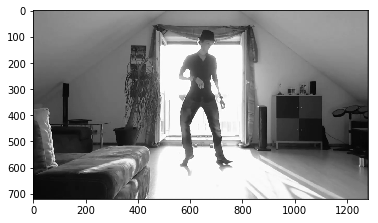

In [11]:
frame = 1000
img_path = pose_dir + '/' + str(frame) + '.jpg'
print(img_path)
image  = mpimg.imread(img_path)
plt.imshow(image)
plt.show()